In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.layouts import column
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
from joblib import dump
#dump(df_final, 'df_final.joblib')

df = pd.read_csv('stroke_dataset.csv')

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [5]:
df.shape

(4981, 11)

In [6]:
print(df.astype)



<bound method NDFrame.astype of       gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1       Male  80.0             0              1          Yes        Private   
2     Female  49.0             0              0          Yes        Private   
3     Female  79.0             1              0          Yes  Self-employed   
4       Male  81.0             0              0          Yes        Private   
...      ...   ...           ...            ...          ...            ...   
4976    Male  41.0             0              0           No        Private   
4977    Male  40.0             0              0          Yes        Private   
4978  Female  45.0             1              0          Yes       Govt_job   
4979    Male  40.0             0              0          Yes        Private   
4980  Female  80.0             1              0          Yes        Private   

     Residence_type

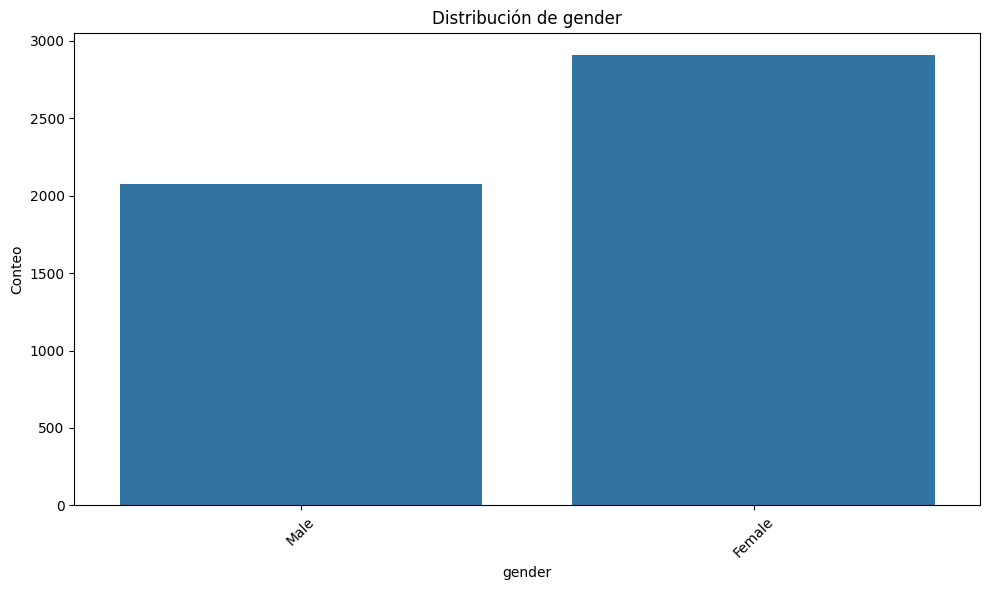

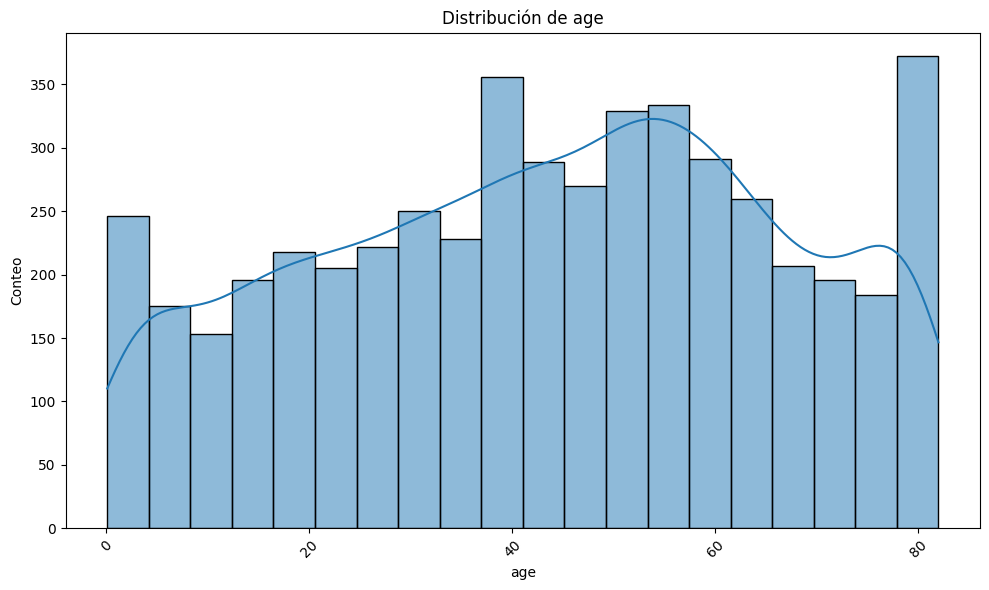

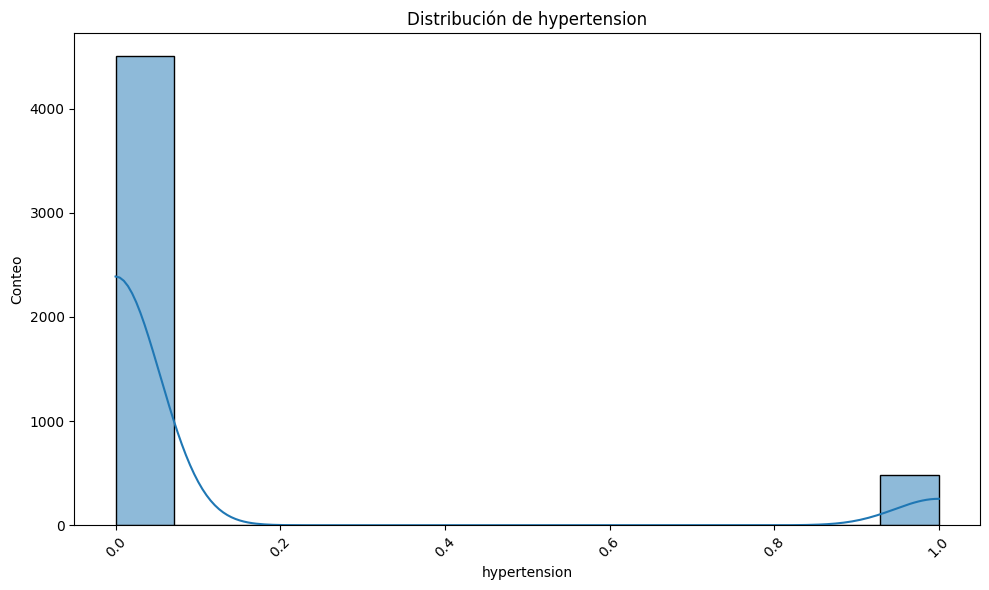

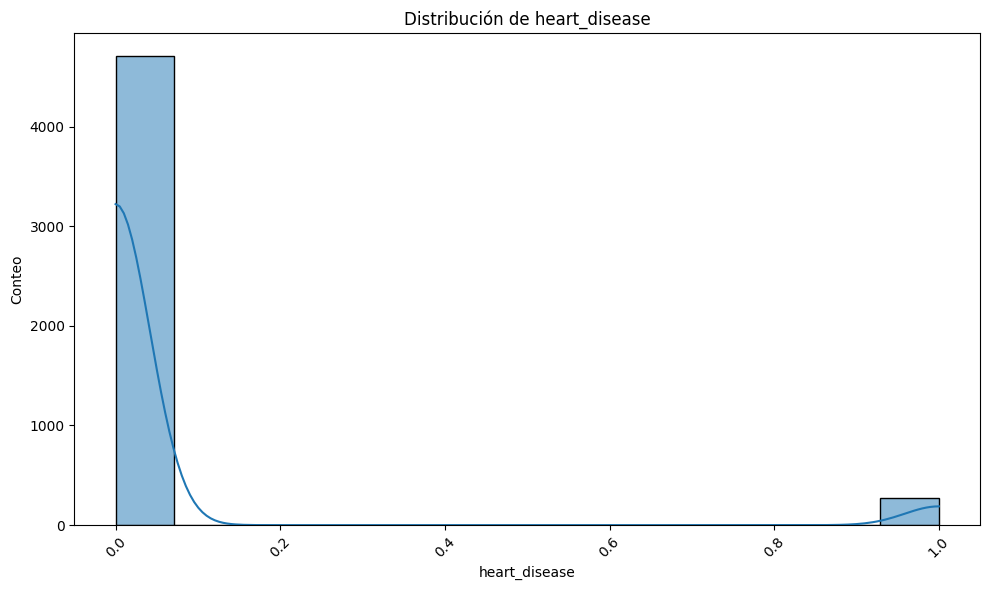

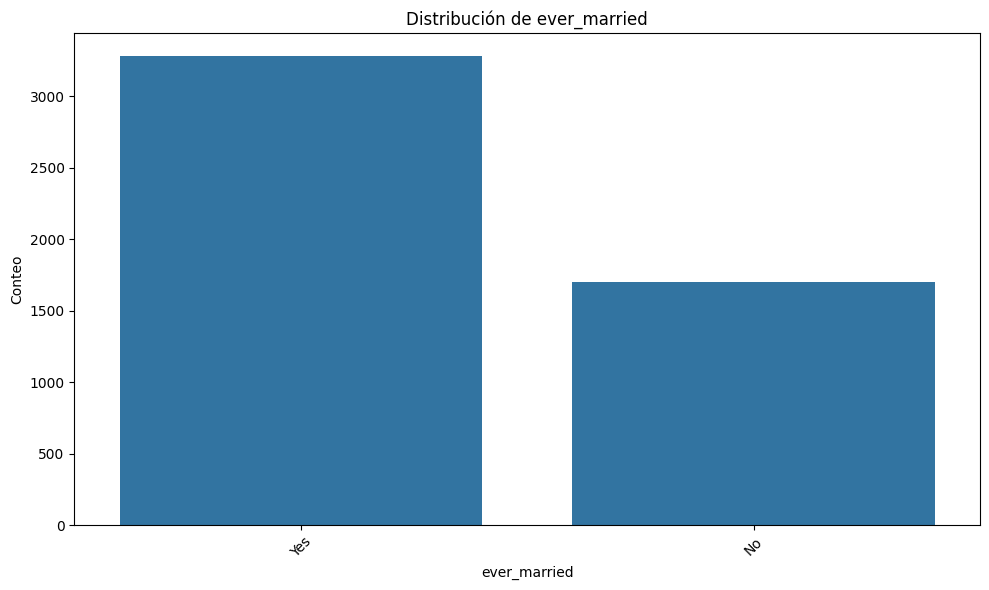

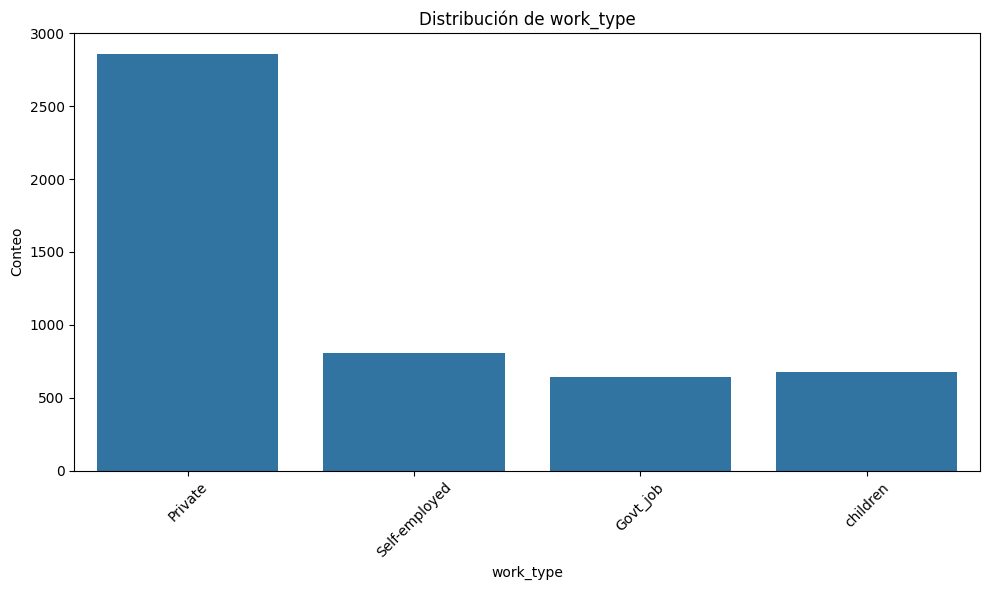

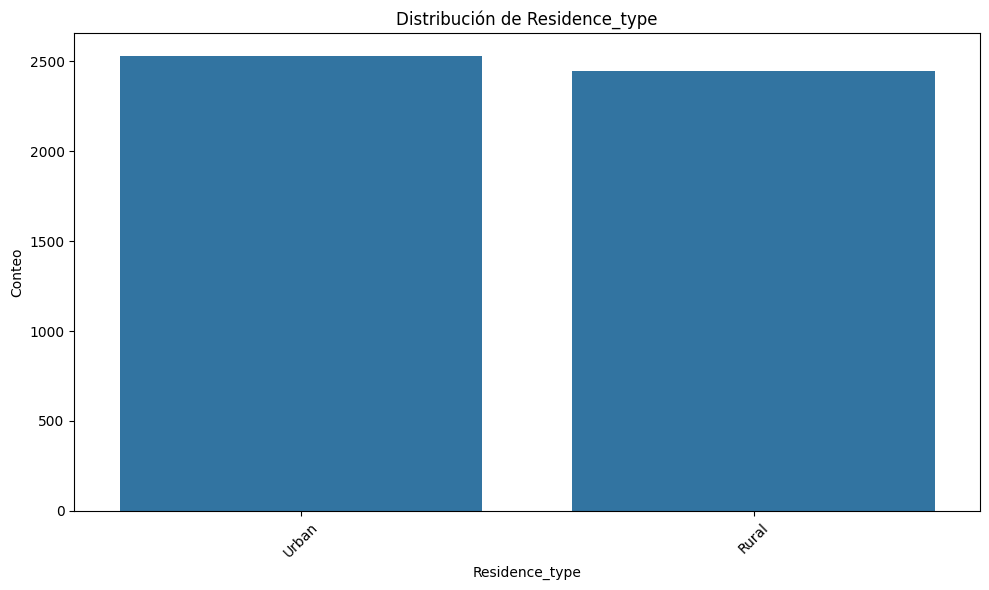

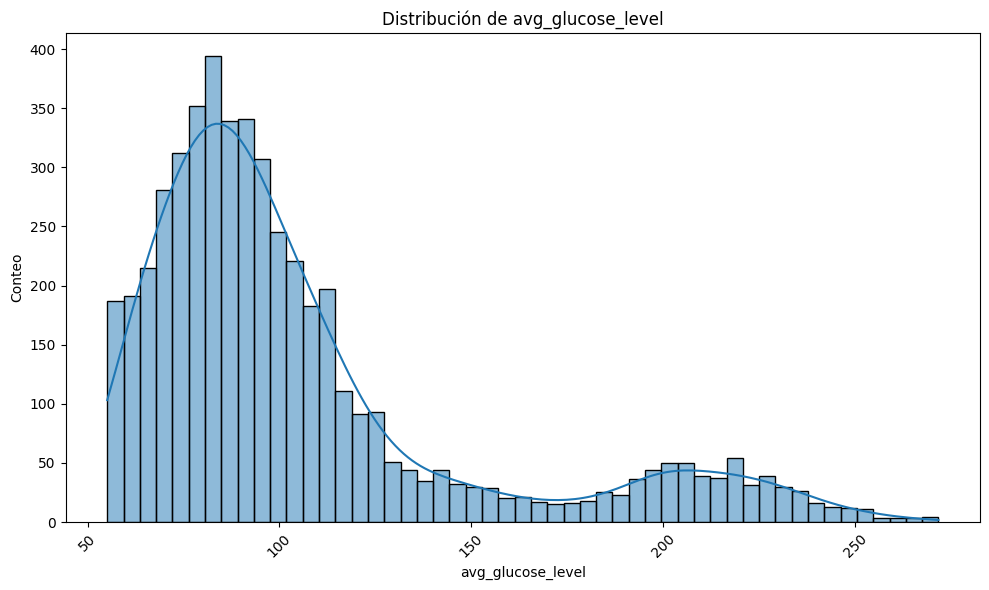

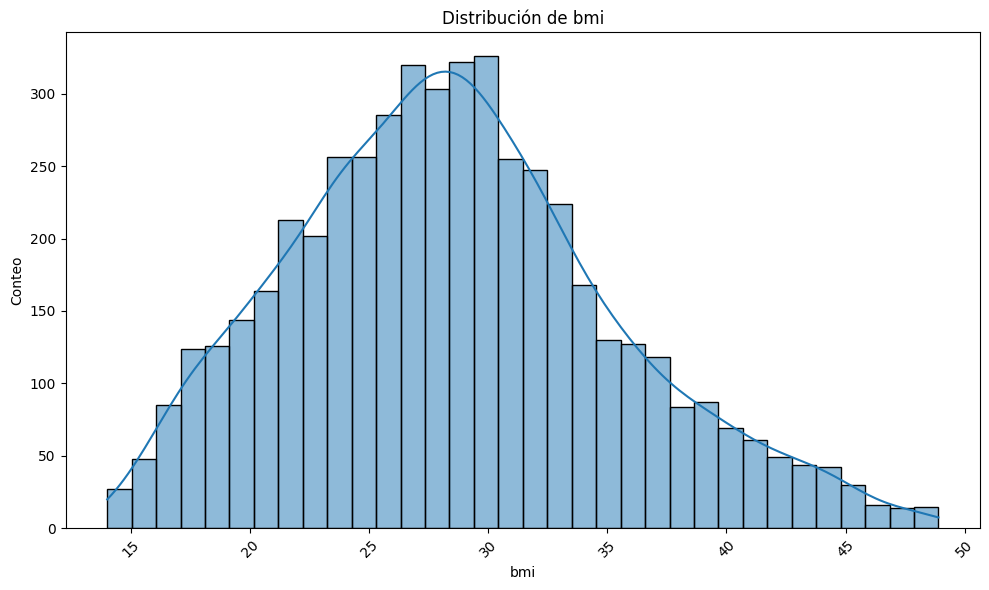

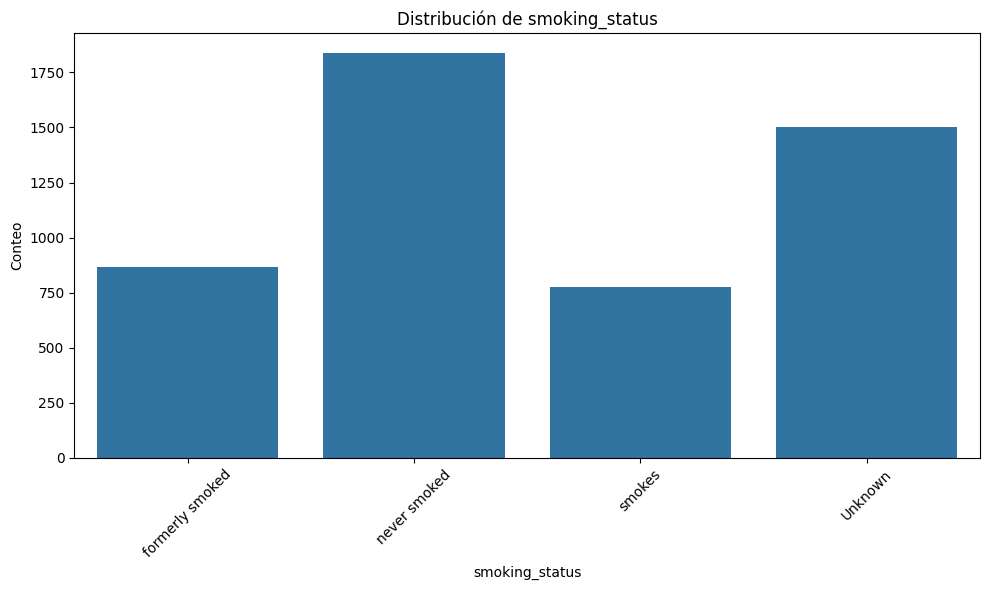

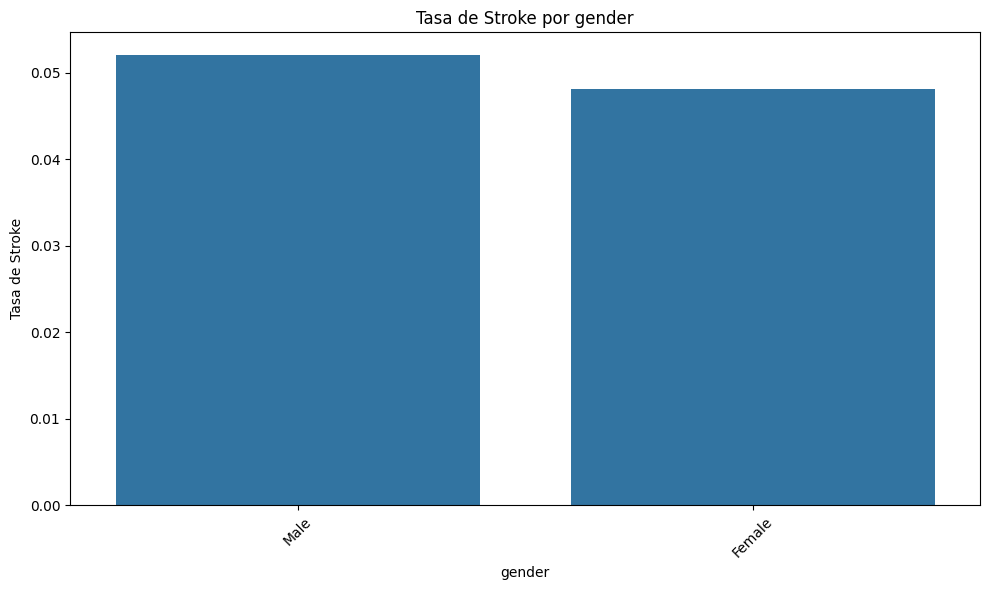

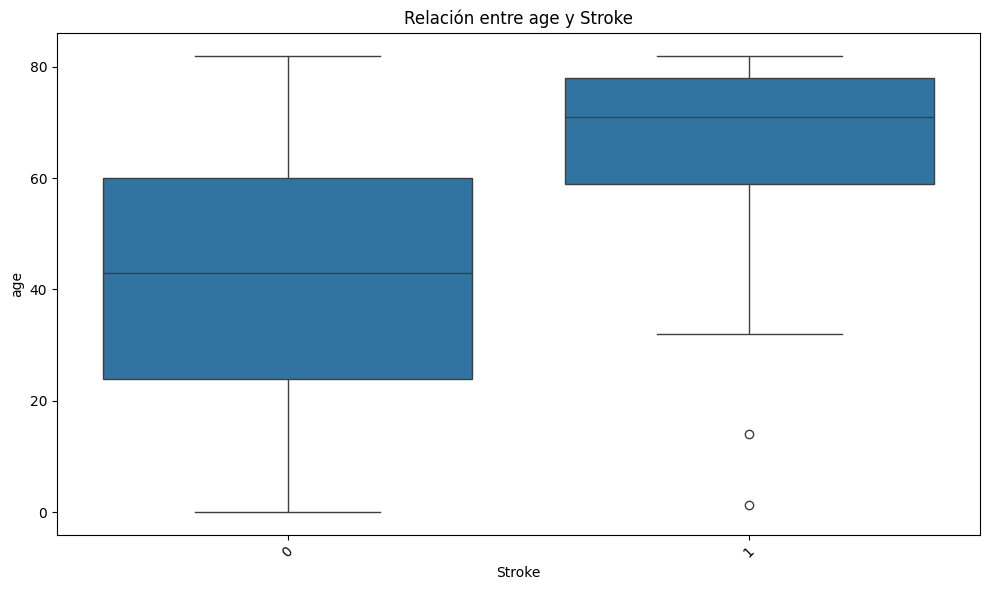

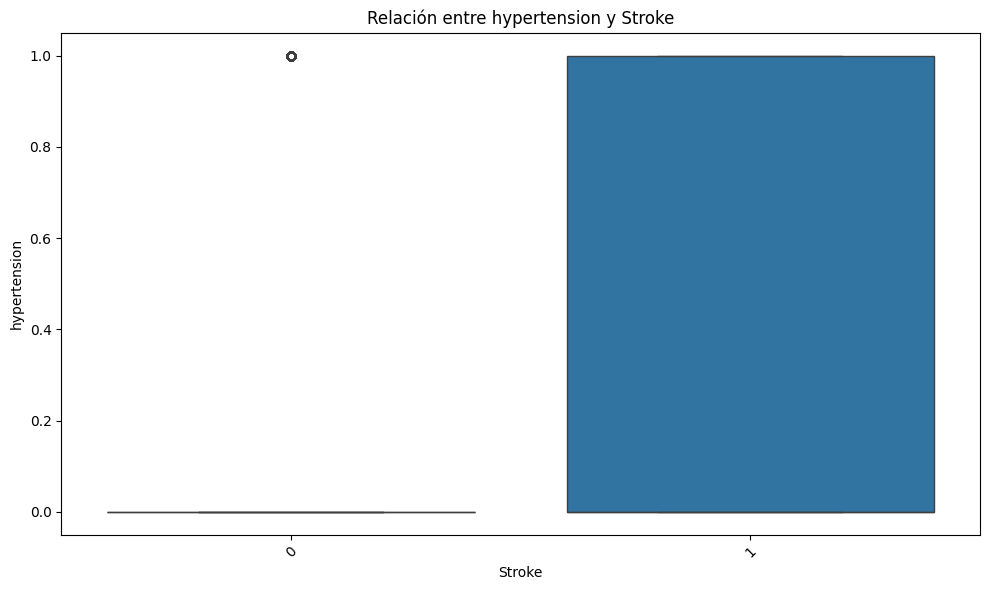

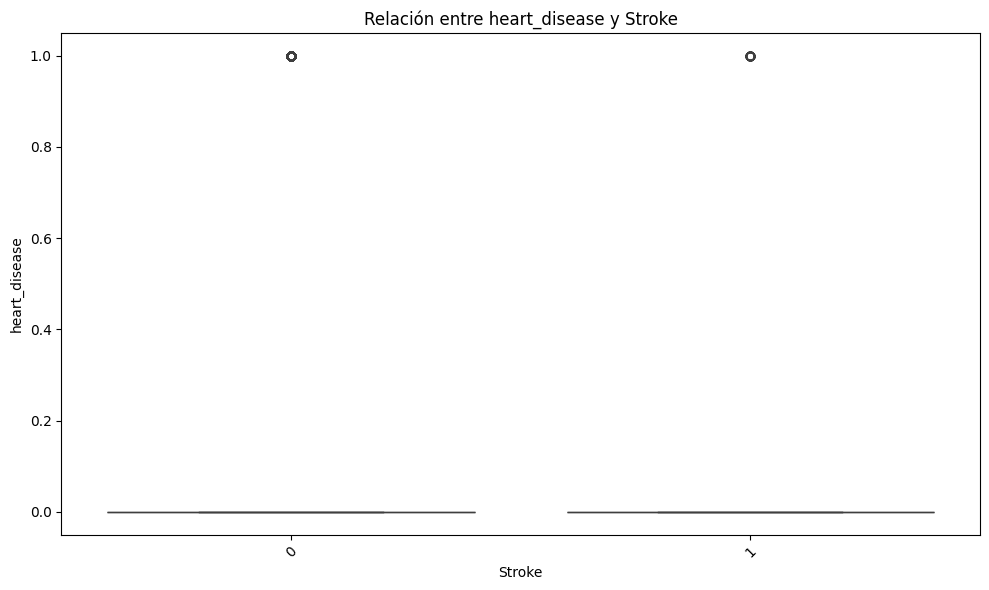

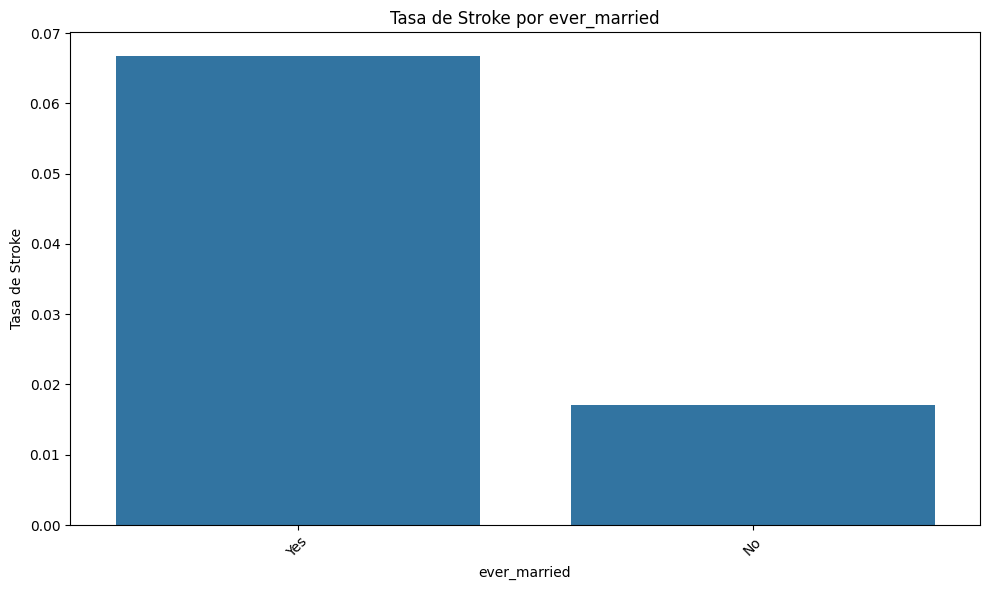

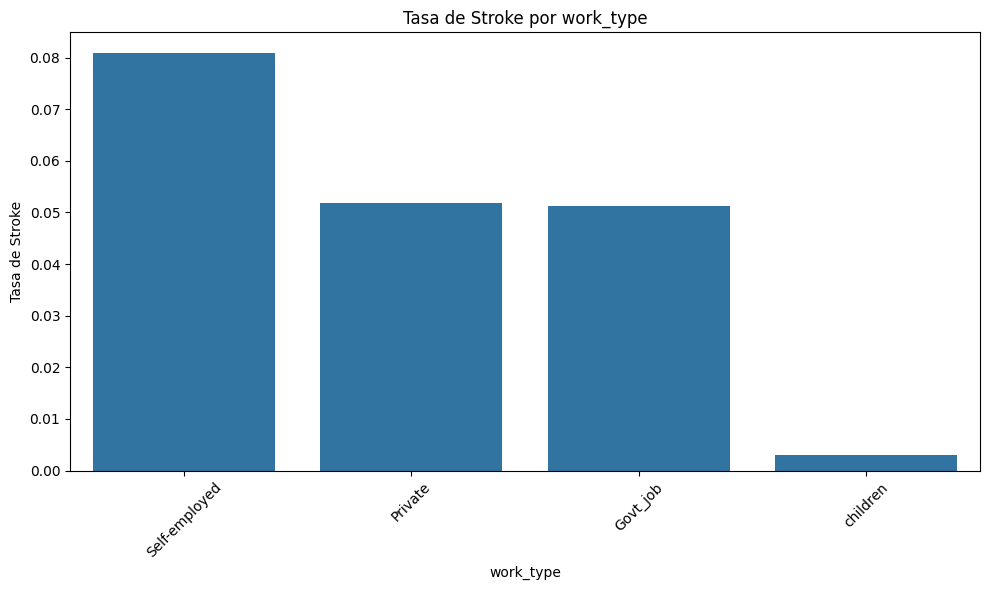

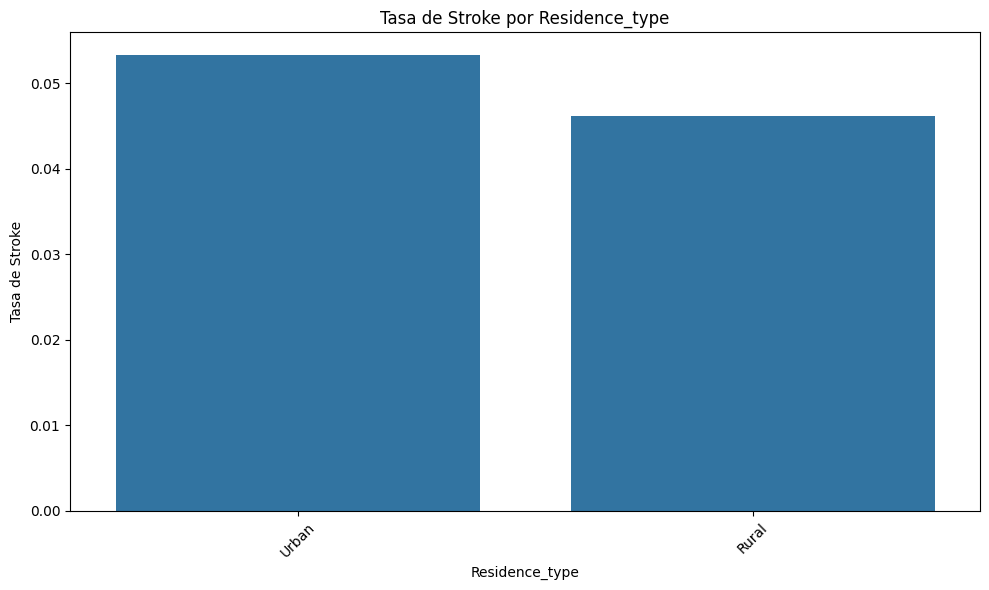

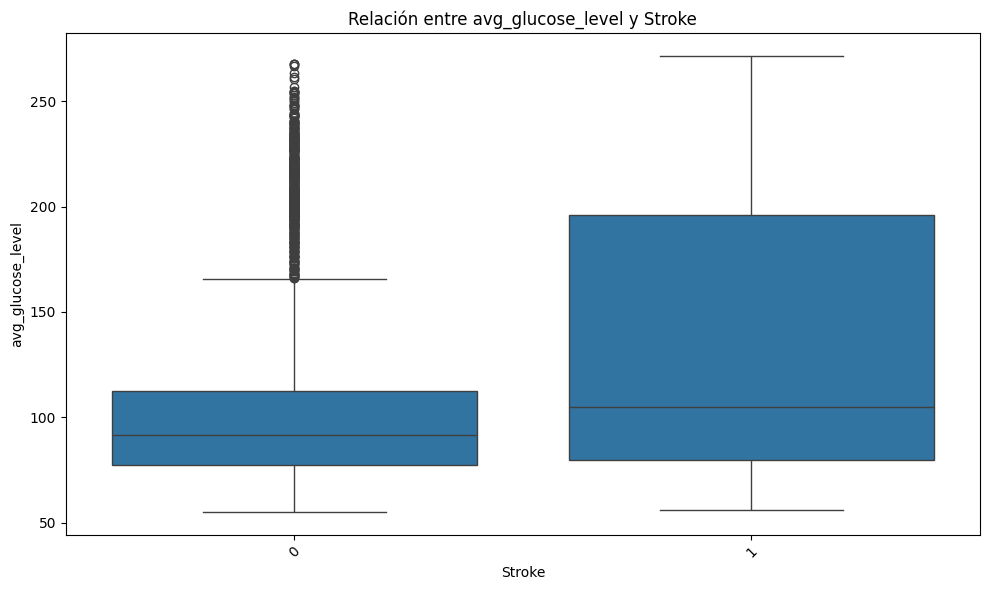

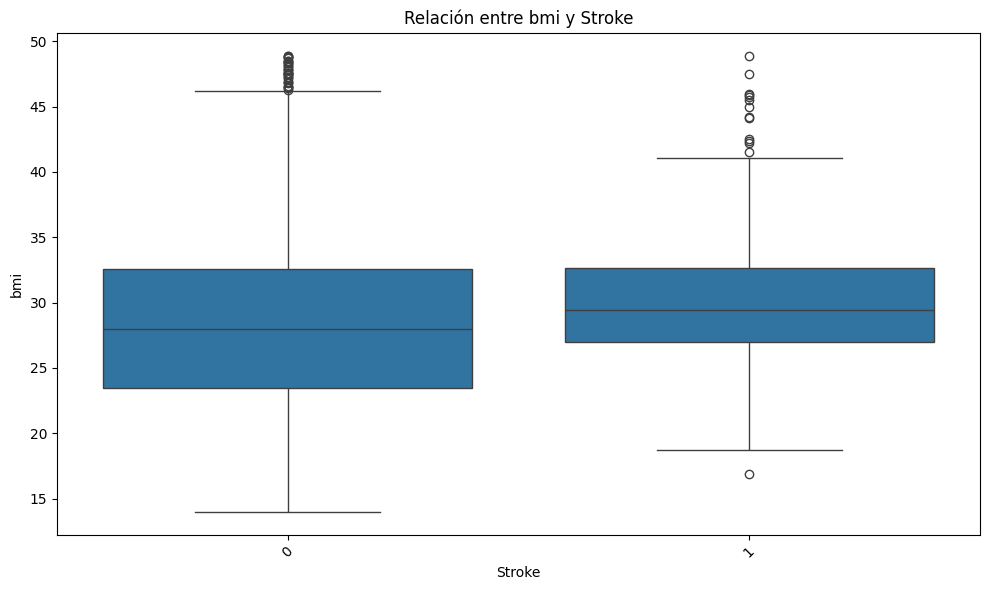

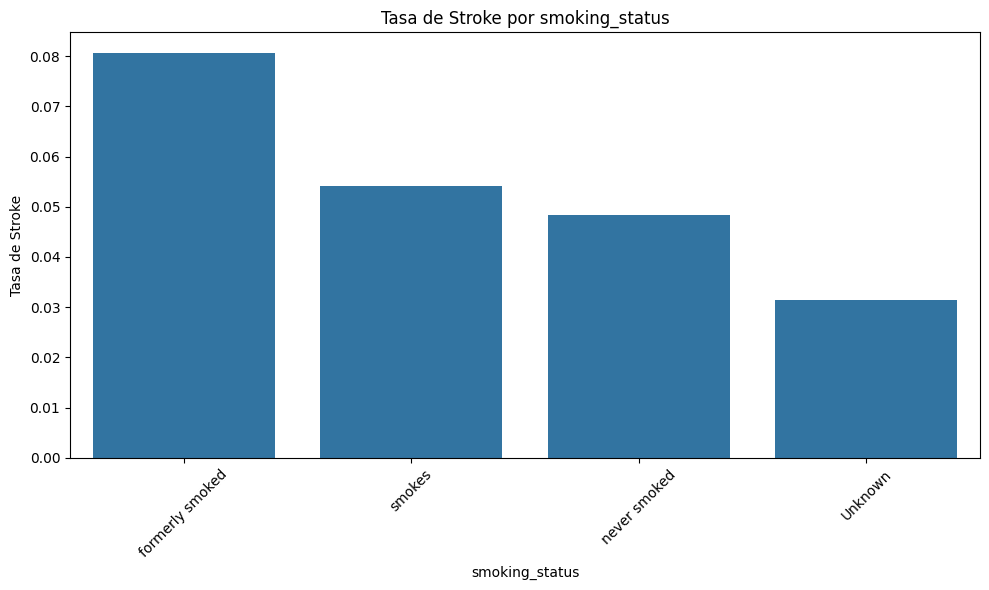

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumiendo que df es tu DataFrame original sin codificar

# Parte 1: Histogramas de todas las características

def plot_histogram(df, column):
    plt.figure(figsize=(10, 6))
    if df[column].dtype in ['int64', 'float64']:
        sns.histplot(data=df, x=column, kde=True)
    else:
        sns.countplot(x=column, data=df)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generar histogramas para todas las variables excepto 'stroke'
for column in df.columns:
    if column != 'stroke':
        plot_histogram(df, column)

# Parte 2: Relaciones de cada característica con stroke

def plot_relation_with_stroke(df, column):
    plt.figure(figsize=(10, 6))
    if df[column].dtype in ['int64', 'float64']:
        # Para variables numéricas, usar boxplot
        sns.boxplot(x='stroke', y=column, data=df)
        plt.title(f'Relación entre {column} y Stroke')
        plt.xlabel('Stroke')
        plt.ylabel(column)
    else:
        # Para variables categóricas, usar barplot
        stroke_rate = df.groupby(column)['stroke'].mean().sort_values(ascending=False)
        sns.barplot(x=stroke_rate.index, y=stroke_rate.values)
        plt.title(f'Tasa de Stroke por {column}')
        plt.xlabel(column)
        plt.ylabel('Tasa de Stroke')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generar gráficos de relación con stroke para todas las variables excepto 'stroke'
for column in df.columns:
    if column != 'stroke':
        plot_relation_with_stroke(df, column)

In [8]:
# Eliminar registros donde la edad es menor a 18 años
df = df[df['age'] >= 18]

# Separar los datos en dos grupos: stroke = 0 y stroke = 1
df_no_stroke = df[df['stroke'] == 0]
df_stroke = df[df['stroke'] == 1]

# Eliminar 'Unknown' de smoking_status donde stroke = 0
df_no_stroke = df_no_stroke[df_no_stroke['smoking_status'] != 'Unknown']

# Calcular la distribución de smoking_status para stroke = 1 (excluyendo 'Unknown')
smoking_dist = df_stroke[df_stroke['smoking_status'] != 'Unknown']['smoking_status'].value_counts(normalize=True)

# Crear una copia de df_stroke para la imputación
df_stroke_imputed = df_stroke.copy()

# Identificar índices donde smoking_status es 'Unknown'
unknown_mask = df_stroke_imputed['smoking_status'] == 'Unknown'

# Imputar valores para los 'Unknown' en stroke = 1
np.random.seed(42)  # Para reproducibilidad
df_stroke_imputed.loc[unknown_mask, 'smoking_status'] = np.random.choice(
    smoking_dist.index, 
    size=unknown_mask.sum(), 
    p=smoking_dist.values
)

# Combinar los dataframes
df_final = pd.concat([df_no_stroke, df_stroke_imputed])

# Verificar las categorías antes del encoding
print("\nCategorías únicas en smoking_status:")
print(df_final['smoking_status'].unique())
print("\nDistribución de smoking_status:")
print(df_final['smoking_status'].value_counts())

# Verificar que no hay 'Unknown'
print("\n¿Hay 'Unknown' en los datos?")
print(df_final['smoking_status'].isin(['Unknown']).any())


Categorías únicas en smoking_status:
['never smoked' 'formerly smoked' 'smokes']

Distribución de smoking_status:
smoking_status
never smoked       1734
formerly smoked     855
smokes              775
Name: count, dtype: int64

¿Hay 'Unknown' en los datos?
False


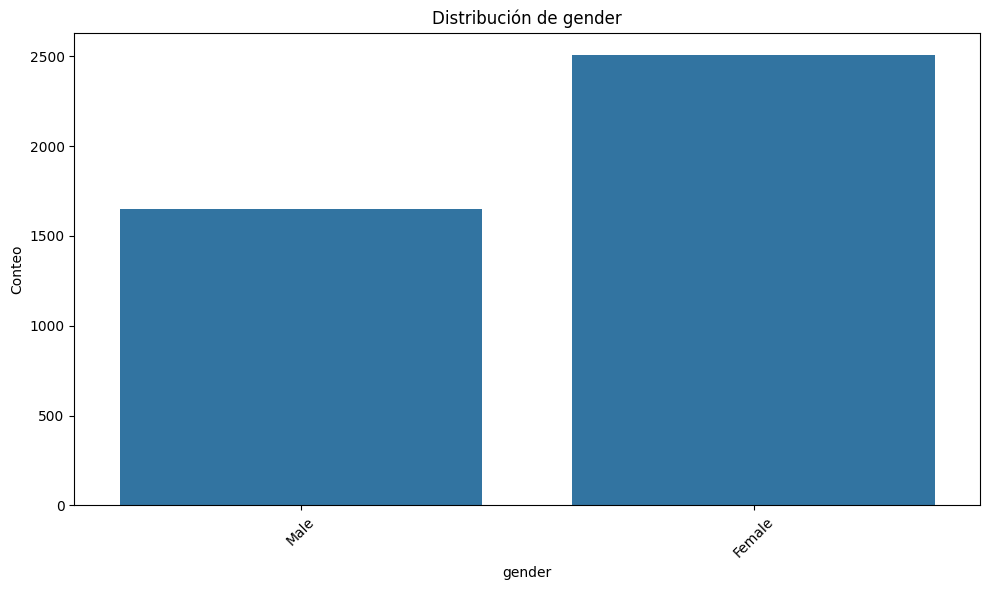

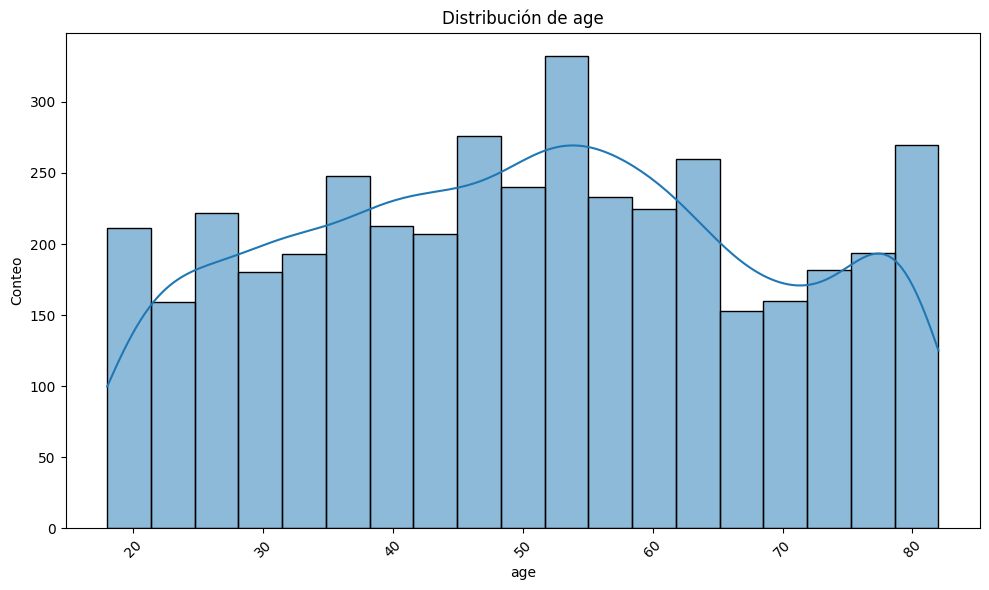

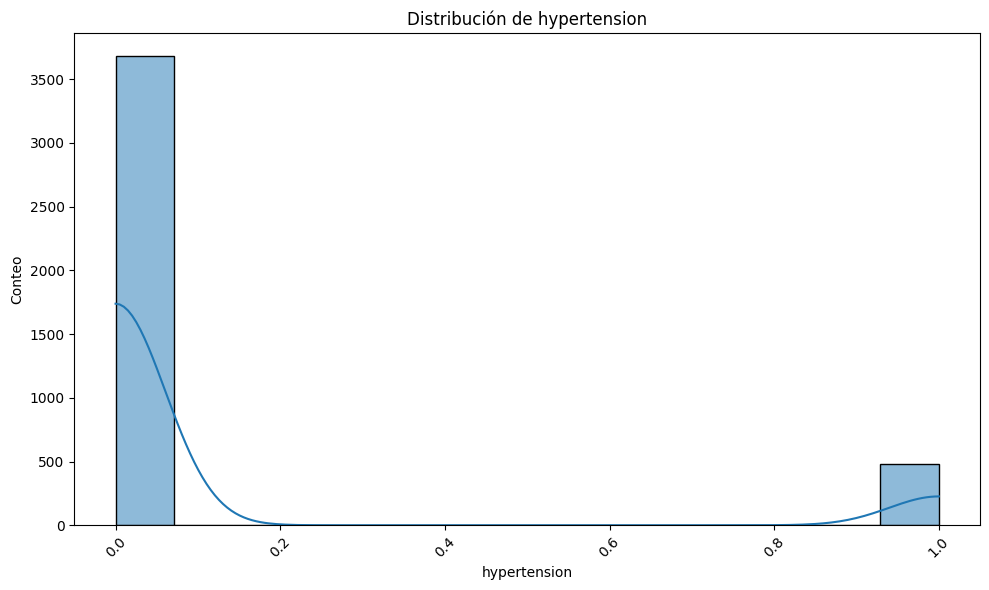

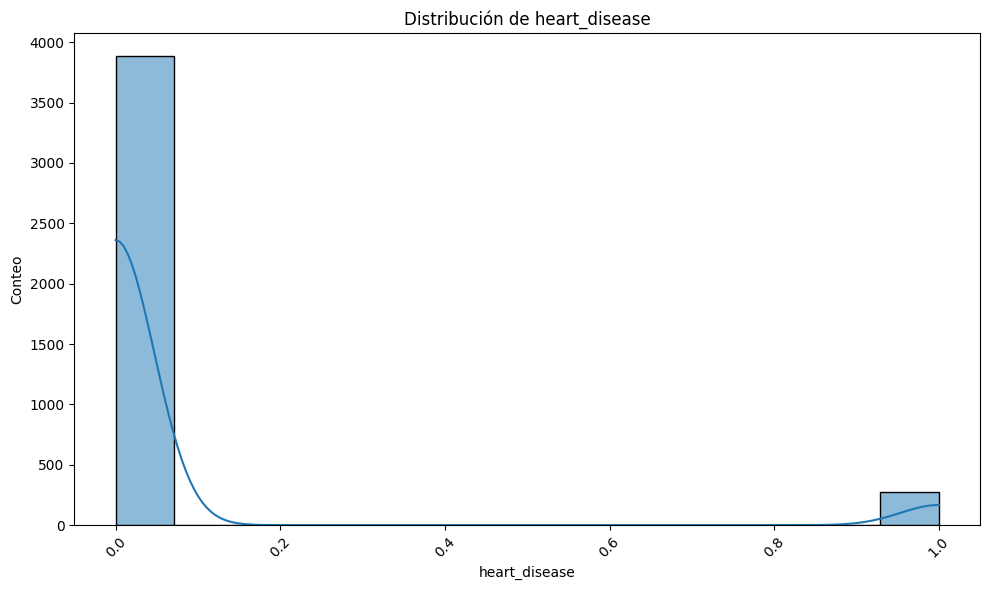

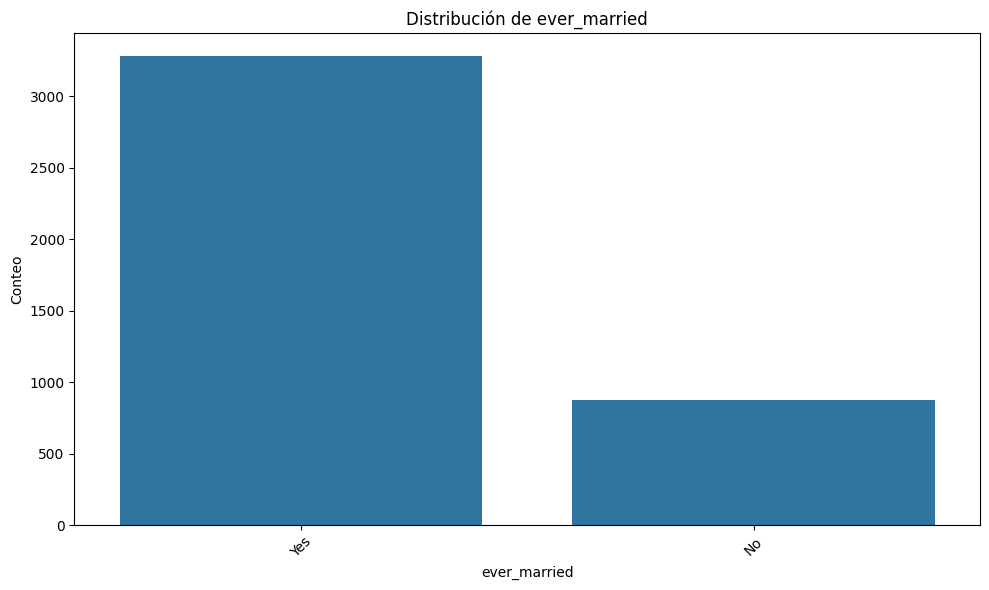

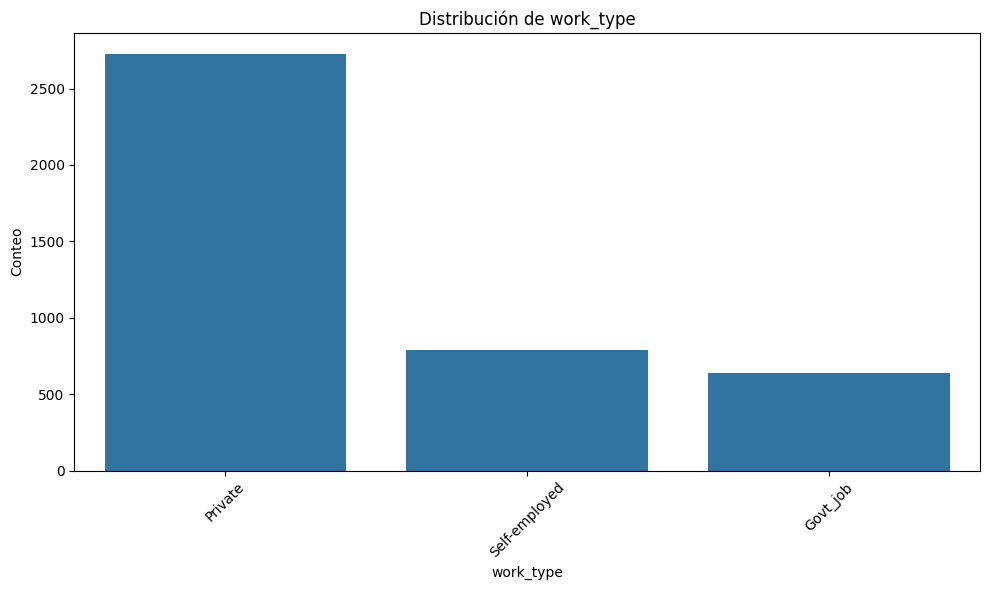

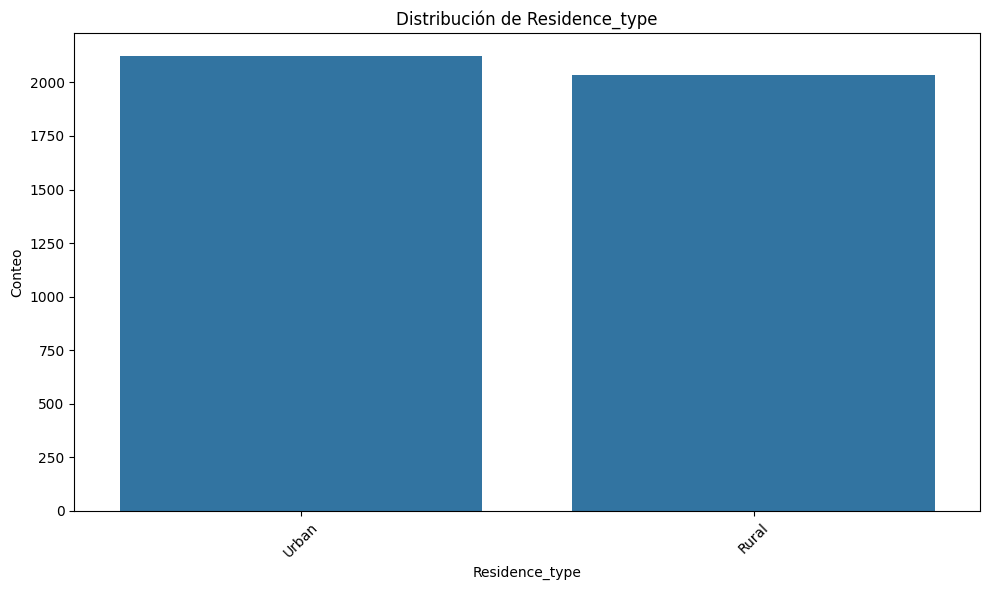

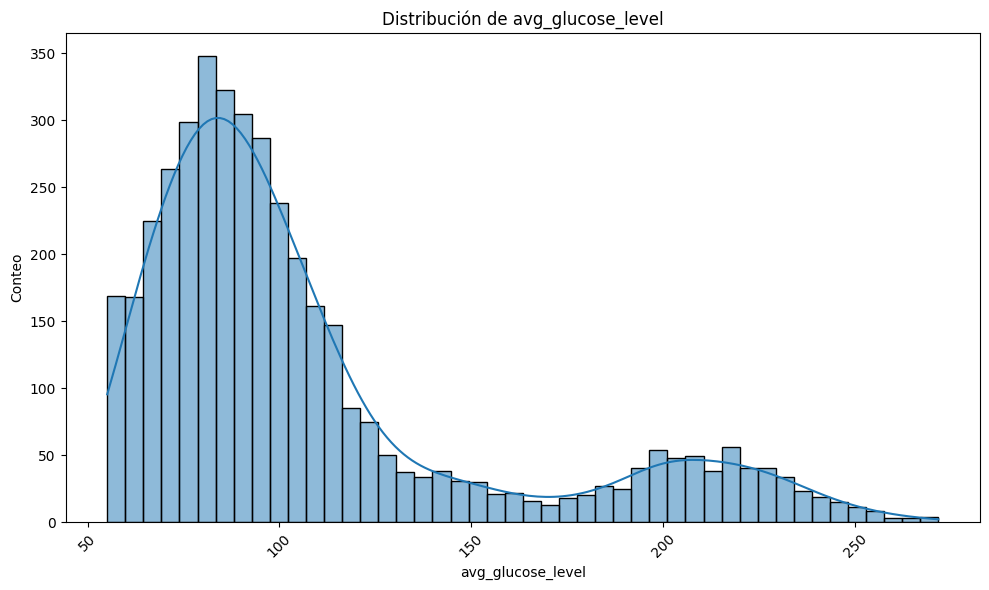

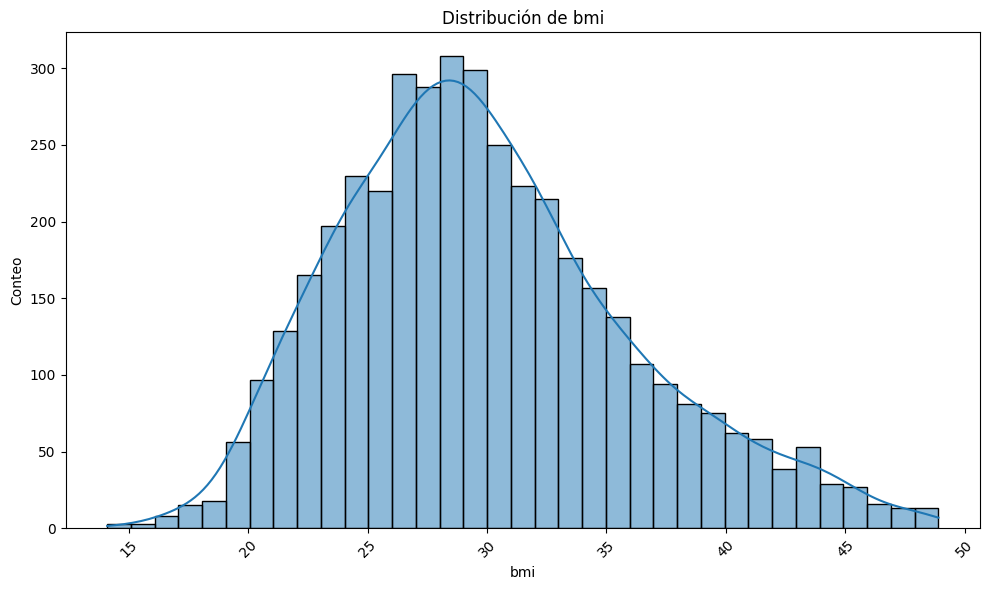

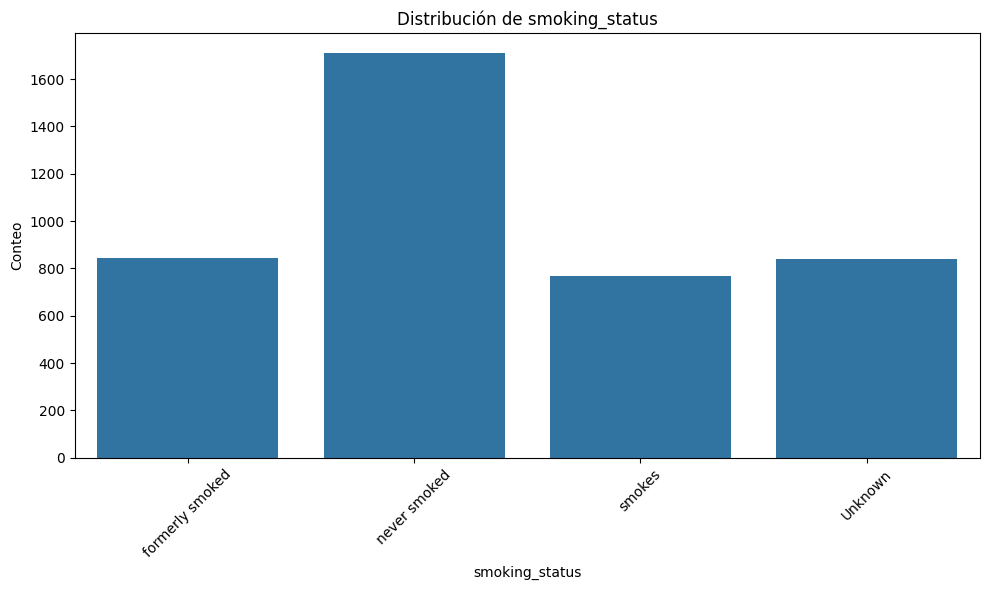

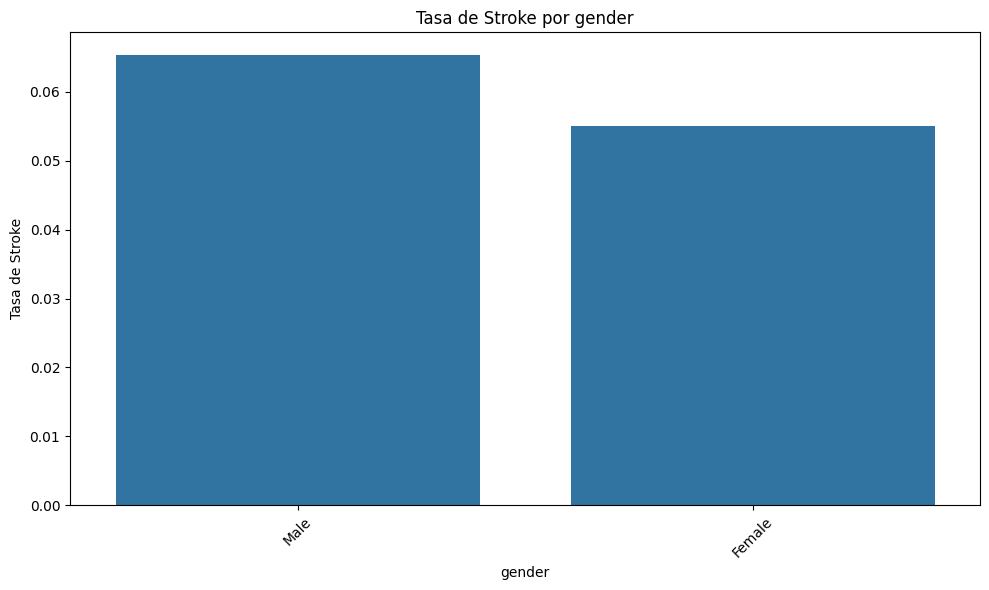

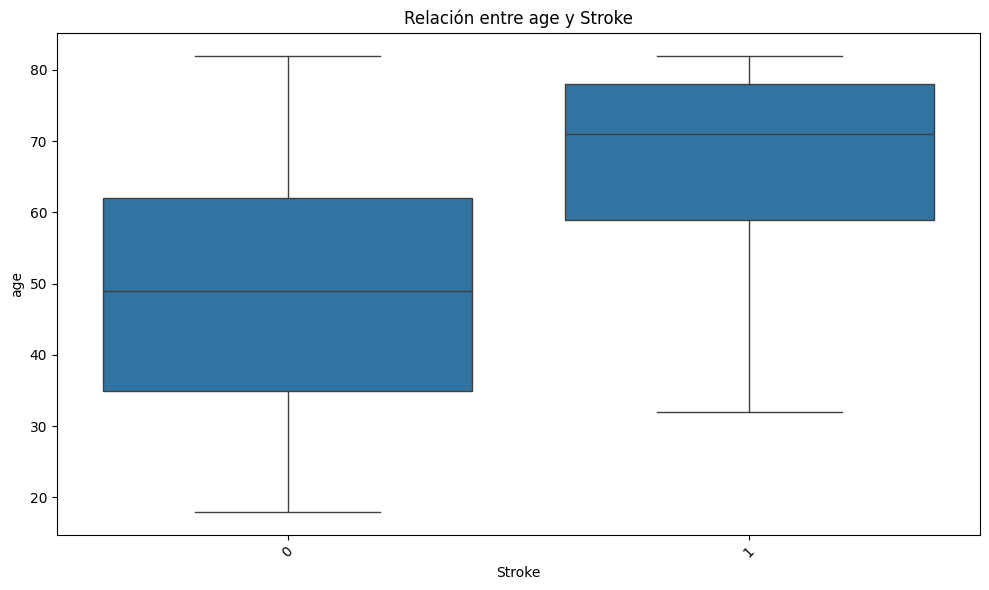

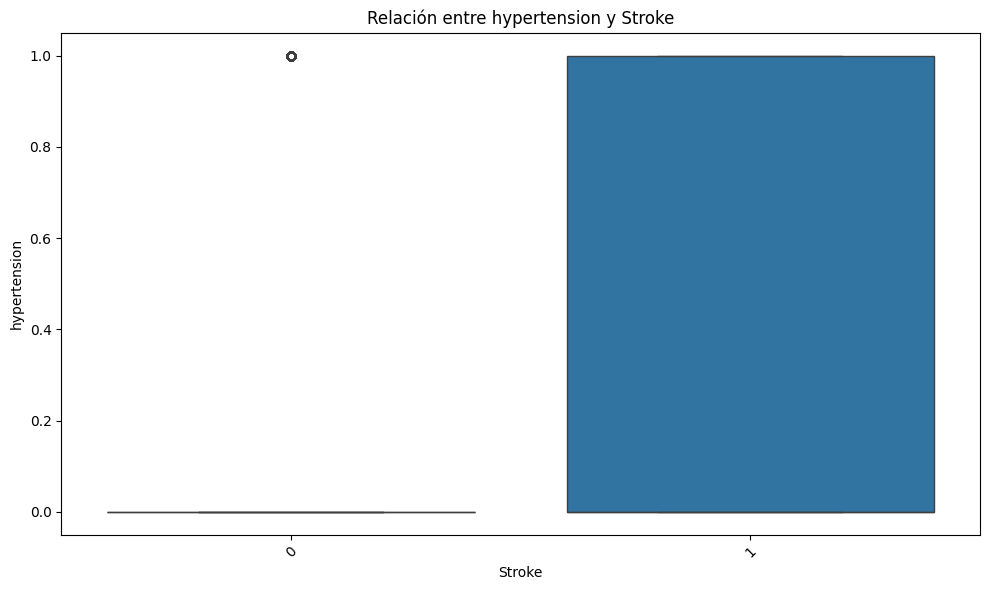

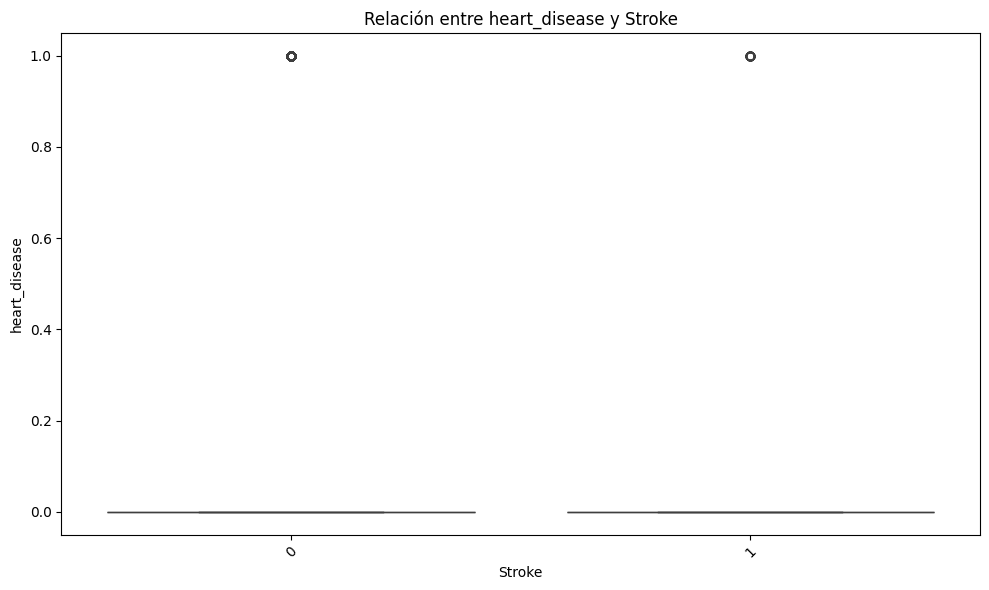

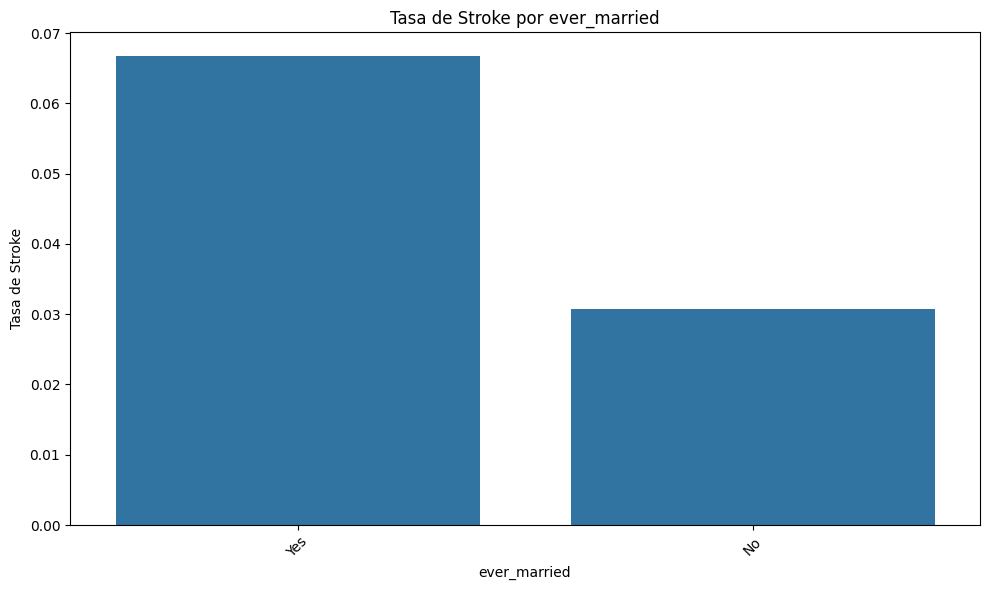

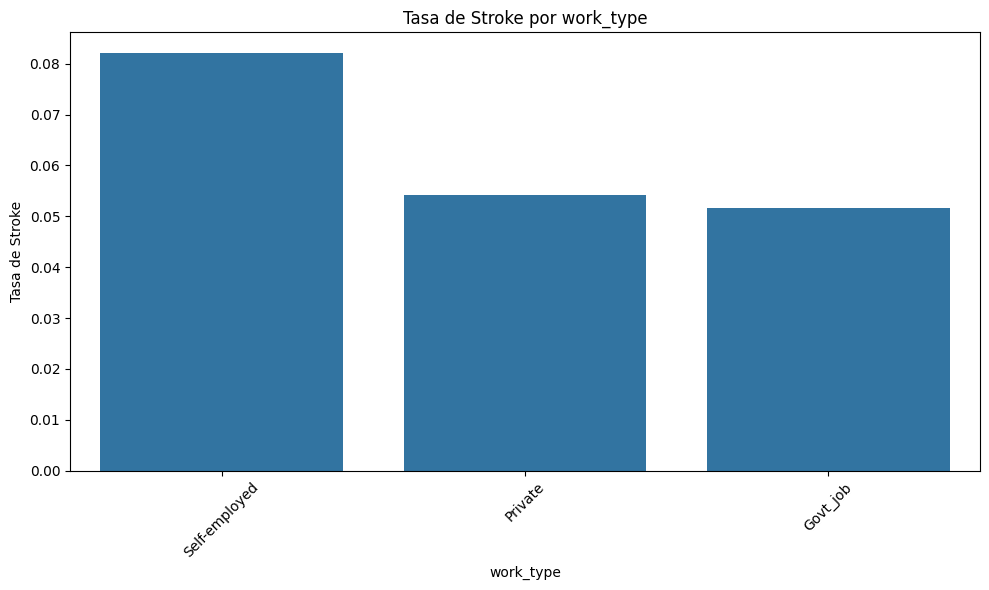

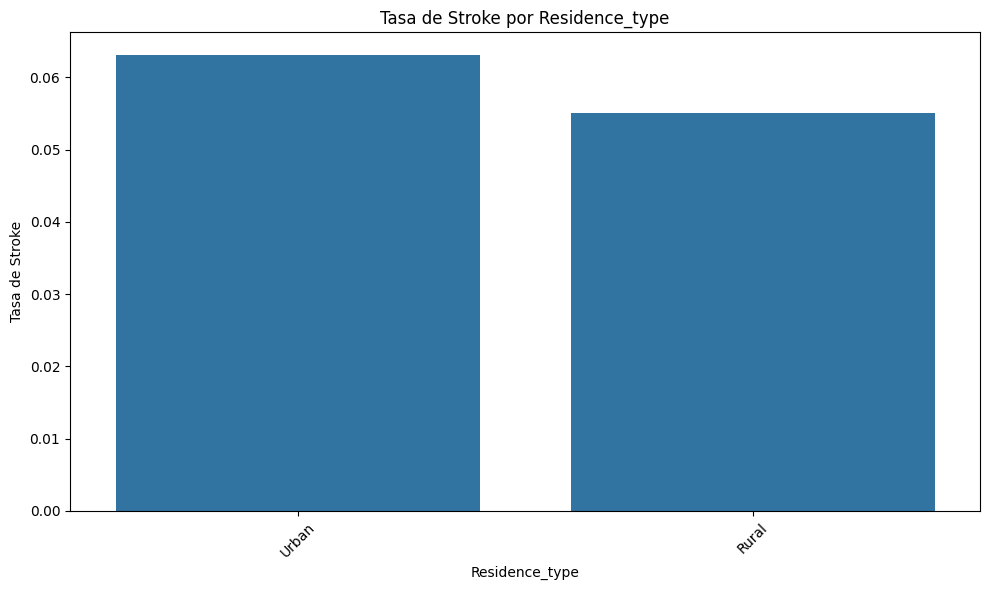

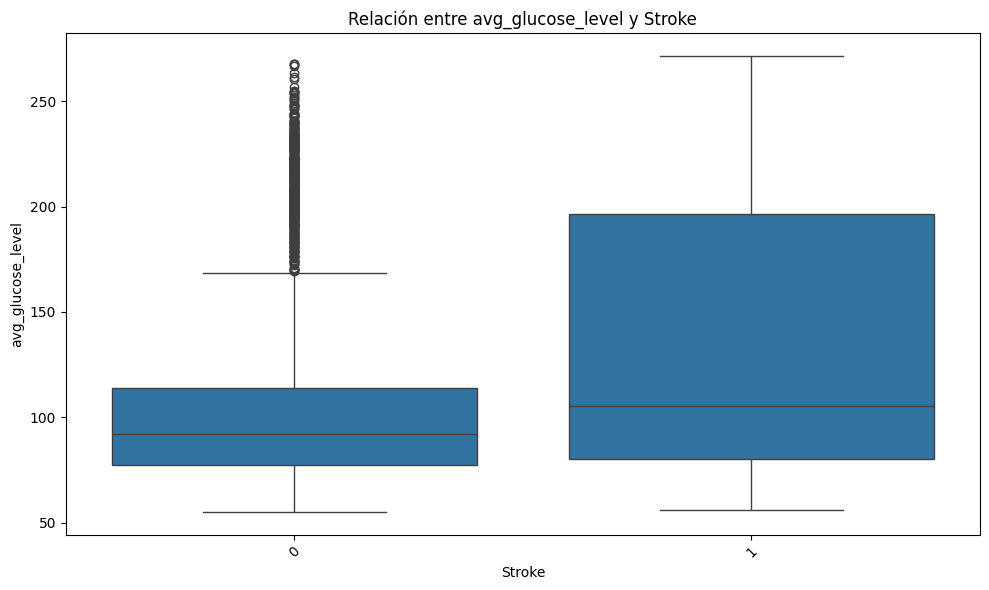

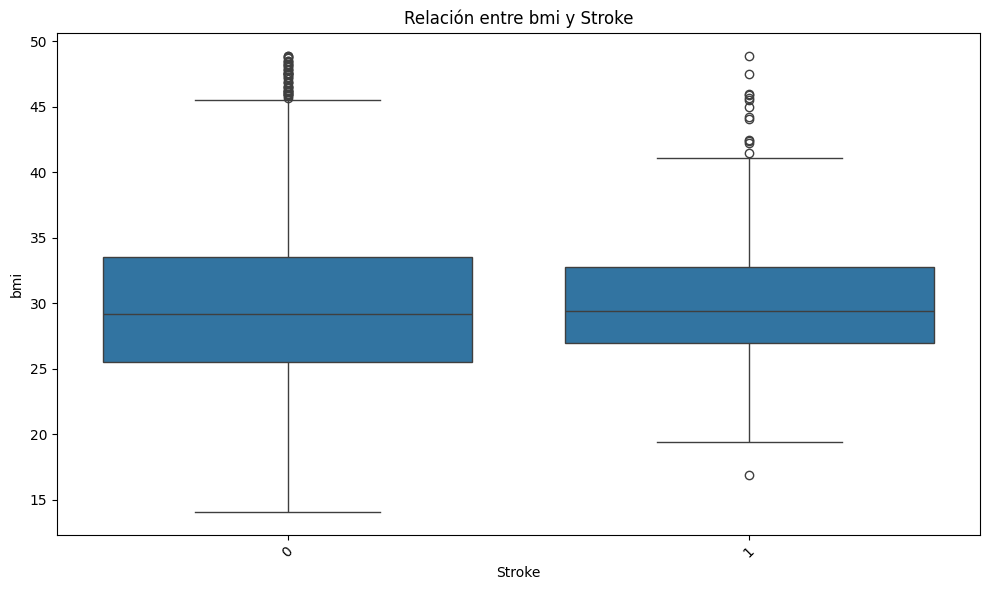

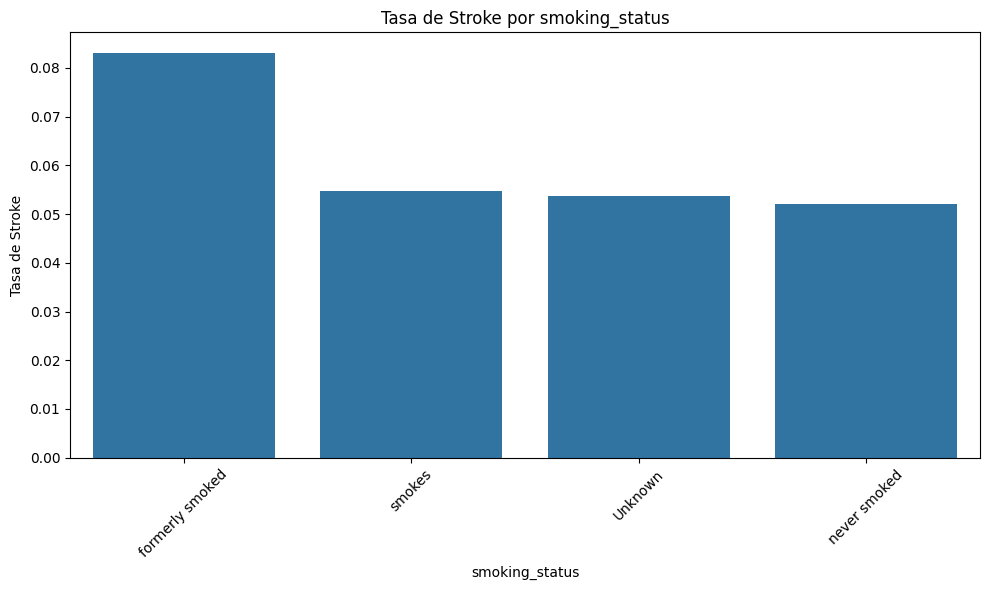

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumiendo que df es tu DataFrame original sin codificar

# Parte 1: Histogramas de todas las características

def plot_histogram(df, column):
    plt.figure(figsize=(10, 6))
    if df[column].dtype in ['int64', 'float64']:
        sns.histplot(data=df, x=column, kde=True)
    else:
        sns.countplot(x=column, data=df)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generar histogramas para todas las variables excepto 'stroke'
for column in df.columns:
    if column != 'stroke':
        plot_histogram(df, column)

# Parte 2: Relaciones de cada característica con stroke

def plot_relation_with_stroke(df, column):
    plt.figure(figsize=(10, 6))
    if df[column].dtype in ['int64', 'float64']:
        # Para variables numéricas, usar boxplot
        sns.boxplot(x='stroke', y=column, data=df)
        plt.title(f'Relación entre {column} y Stroke')
        plt.xlabel('Stroke')
        plt.ylabel(column)
    else:
        # Para variables categóricas, usar barplot
        stroke_rate = df.groupby(column)['stroke'].mean().sort_values(ascending=False)
        sns.barplot(x=stroke_rate.index, y=stroke_rate.values)
        plt.title(f'Tasa de Stroke por {column}')
        plt.xlabel(column)
        plt.ylabel('Tasa de Stroke')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generar gráficos de relación con stroke para todas las variables excepto 'stroke'
for column in df.columns:
    if column != 'stroke':
        plot_relation_with_stroke(df, column)

In [10]:
def encode_categorical(df, categorical_columns):
    df_encoded = df.copy()
    encoders = {}
    
    for col in categorical_columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
    
    return df_encoded, encoders

# Usar la función
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded, encoders = encode_categorical(df, categorical_columns)

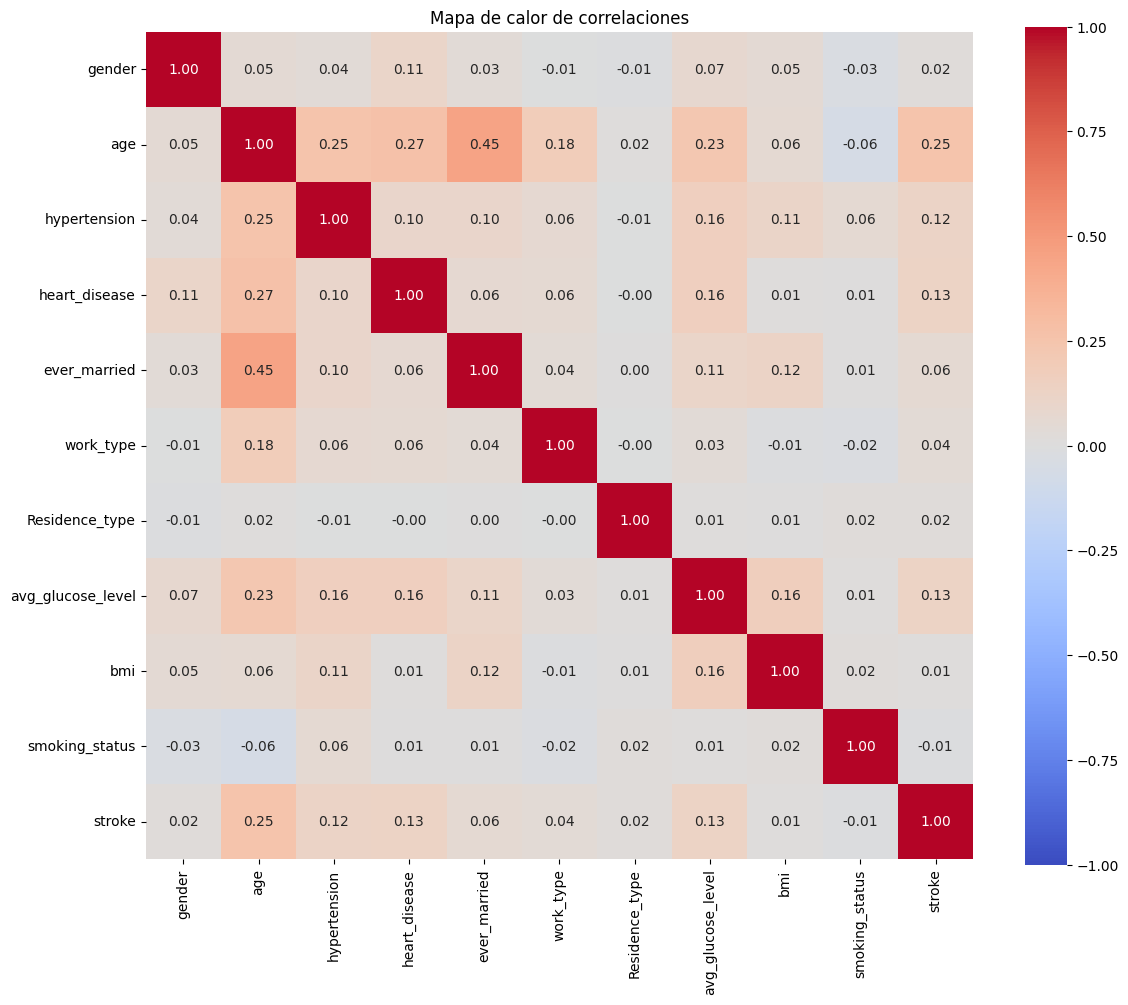

In [11]:

# Calcular la matriz de correlación
corr_matrix = df_encoded.corr()

# Crear un mapa de calor de correlaciones con los valores dentro de cada cuadro
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)
plt.title('Mapa de calor de correlaciones')
plt.tight_layout()
plt.show()

In [12]:
def decode_column(series, encoder):
    return encoder.inverse_transform(series)

def decode_dataframe(df, encoders):
    df_decoded = df.copy()
    for col, encoder in encoders.items():
        df_decoded[col] = decode_column(df[col], encoder)
    return df_decoded